# Autoencoders Assignment

In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

import zipfile
import pathlib

In [2]:
# Loading the dataset
# Defining ZIP file path
#zip_path = "/content/Lightbulb (2).zip"

# extracted file content directory
#extract_dir = "/content/lightbulb"

# Contents of extracted file
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_dir)

In [3]:
# Defining dataset directory
data_dir = pathlib.Path('C:/MSDA 302 DEEP LEARNING WITH TENSORFLOW/Week 8/Lightbulb')

# train directory
train_dir = data_dir/'train'

# validation directory
valid_dir = data_dir/'val'

# test directory
test_dir = data_dir/'test'

In [4]:
# Creating TensorFlow dataset
image_size = (64, 64)
batch_size = 16
# train set
train_set = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size = image_size,
    batch_size = batch_size)

# validation set
val_set = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    image_size = image_size,
    batch_size = batch_size)

# test set
test_set = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size = image_size,
    batch_size = batch_size)

Found 239 files belonging to 1 classes.
Found 33 files belonging to 1 classes.


Found 85 files belonging to 1 classes.


In [5]:
# Normalizing the image data
# Rescaling image pixel values to the range [0, 1]
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)

# map function applies the normalization to train, validation and test sets
train_set = train_set.map(lambda x, y: (normalization_layer(x), y))
val_set = val_set.map(lambda x, y: (normalization_layer(x), y))
test_set = test_set.map(lambda x, y: (normalization_layer(x), y))

In [6]:
# Converting train and validation sets to NumPy arrays
train_set = np.concatenate([x for x, _ in train_set], axis = 0)
val_set = np.concatenate([x for x, _ in val_set], axis = 0)

In [7]:
# Adding noise to the images
noise_factor = 0.2
train_noisy = train_set + noise_factor * np.random.normal(size = train_set.shape)
val_noisy = val_set + noise_factor * np.random.normal(size = val_set.shape)

# Clipping the noisy images to the range [0, 1]
train_noisy = np.clip(train_noisy, 0., 1.)
val_noisy = np.clip(val_noisy, 0., 1.)

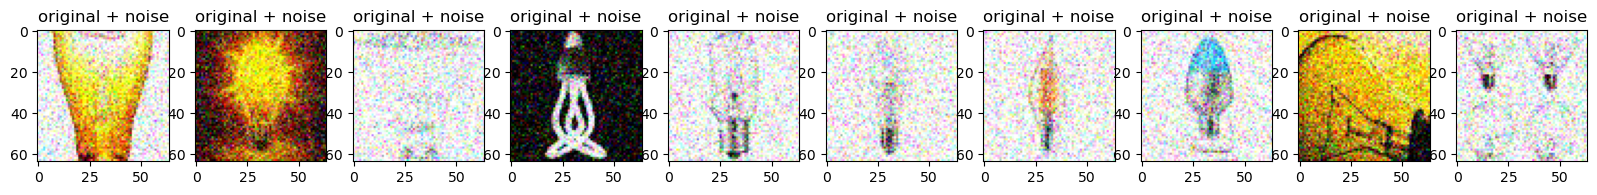

In [8]:
# visualizing 10 samples of validation noisy images
n = 10
plt.figure(figsize = (20, 2))
for i in range(n):
  ax = plt.subplot(1, n, i + 1)
  plt.title("original + noise")
  plt.imshow(tf.squeeze(val_noisy[i]))
  plt.gray()
plt.show()

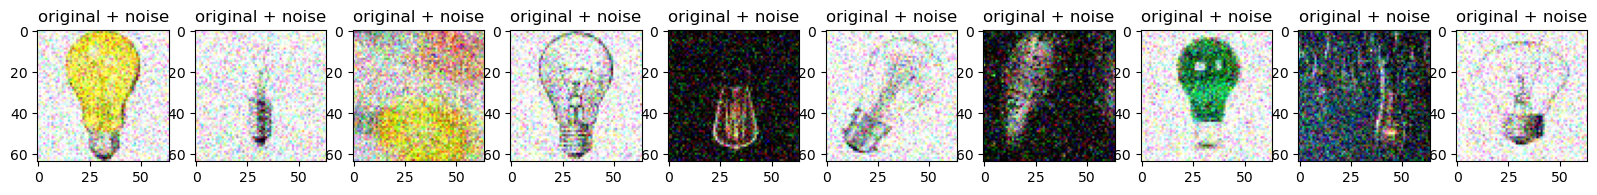

In [9]:
# visualizing 10 samples of training noisy images
n = 10
plt.figure(figsize = (20, 2))
for i in range(n):
  ax = plt.subplot(1, n, i + 1)
  plt.title("original + noise")
  plt.imshow(tf.squeeze(train_noisy[i]))
  plt.gray()
plt.show()

In [10]:
# Defining a convolutional autoencoder using 'Denoise' class
# Using 2 Conv2D layers in the encoder, and 2 Conv2DTranspose layers in the decoder
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    # Encoder
    self.encoder = tf.keras.Sequential([
        layers.Input(shape = (64, 64, 3)), # input layer
        layers.Conv2D(32, kernel_size = 3, activation = 'relu', padding = 'same', strides = 2), # 1st Conv2D layer
        layers.Conv2D(16, kernel_size = 3, activation = 'relu', padding = 'same', strides = 2)]) # 2nd Conv2D layer

    # Decoder
    self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(16, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same'), # 1st Conv2DTranspose layer
        layers.Conv2DTranspose(32, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same'), # 2nd Conv2DTranspose layer
        # final Conv2D layer to reconstruct the original image
        layers.Conv2D(3, kernel_size = 3, activation = 'sigmoid', padding = 'same')])
  # defining forward pass of the autoencoder; takes an input image x
  def call(self, x):
    encoded = self.encoder(x) # passing the image through the encoder
    decoded = self.decoder(encoded) #  passing the image through the decoder to obtain the reconstructed image
    return decoded
# Calling the Denoise class
autoencoder = Denoise()

In [11]:
# Compiling the model
autoencoder.compile(optimizer = 'adam', loss = losses.MeanSquaredError())

In [12]:
# Training the model for 100 epochs
epochs = 100
history = autoencoder.fit(train_noisy, train_set,
                          epochs = epochs,
                          shuffle = True,
                          validation_data = (val_noisy, val_set))

Epoch 1/100


8/8 [==============================] - 14s 702ms/step - loss: 0.1727 - val_loss: 0.1819
Epoch 2/100
8/8 [==============================] - 4s 478ms/step - loss: 0.1552 - val_loss: 0.1387
Epoch 3/100
8/8 [==============================] - 3s 424ms/step - loss: 0.1054 - val_loss: 0.0857
Epoch 4/100
8/8 [==============================] - 4s 544ms/step - loss: 0.0841 - val_loss: 0.0803
Epoch 5/100
8/8 [==============================] - 5s 628ms/step - loss: 0.0761 - val_loss: 0.0741
Epoch 6/100
8/8 [==============================] - 4s 492ms/step - loss: 0.0695 - val_loss: 0.0673
Epoch 7/100
8/8 [==============================] - 4s 466ms/step - loss: 0.0623 - val_loss: 0.0601
Epoch 8/100
8/8 [==============================] - 6s 726ms/step - loss: 0.0564 - val_loss: 0.0558
Epoch 9/100
8/8 [==============================] - 5s 629ms/step - loss: 0.0529 - val_loss: 0.0527
Epoch 10/100
8/8 [==============================] - 4s 440ms/step - loss: 0.0506 - val_loss: 0.0505
Epoch 11/100
8/8 [==

In [13]:
# Summary of encoder
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        4624      
                                                                 
Total params: 5520 (21.56 KB)
Trainable params: 5520 (21.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The images are downsampled from 64 by 64 to 16 by 16

In [14]:
# Summary of decoder
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 32, 32, 16)        2320      
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 64, 64, 32)        4640      
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 3)         867       
                                                                 
Total params: 7827 (30.57 KB)
Trainable params: 7827 (30.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The images are upsampled back from 16 by 16 to 64 by 64

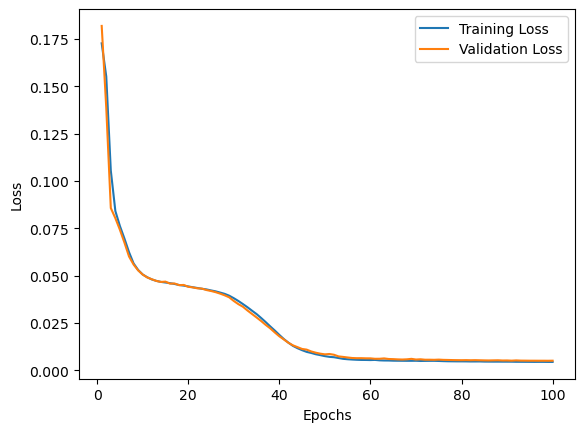

In [15]:
# Plotting the loss curves
plt.plot(range(1, epochs + 1), history.history['loss'], label = 'Training Loss')
plt.plot(range(1, epochs + 1), history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

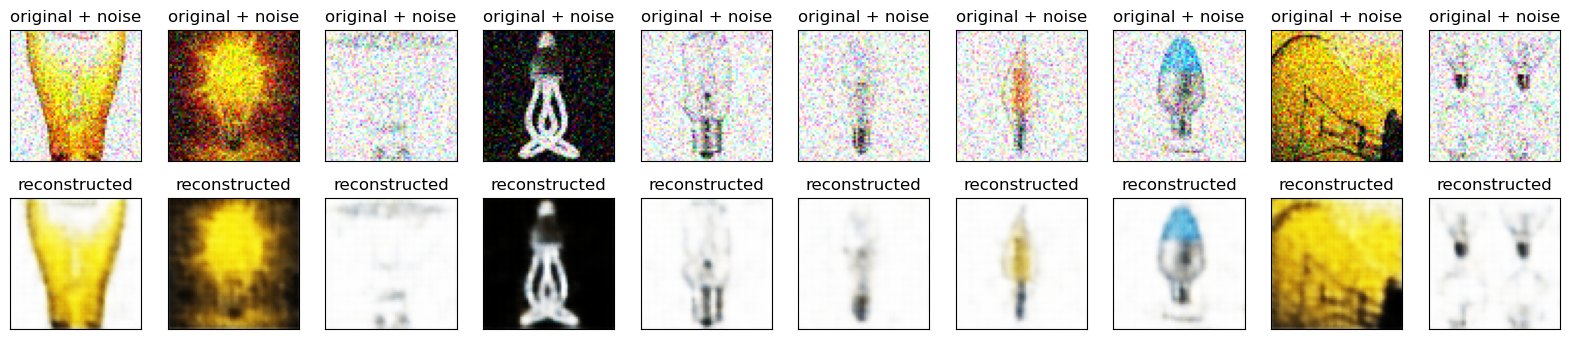

In [16]:
# Plotting both the noisy images and the denoised images produced by the autoencoder.
encoded_imgs = autoencoder.encoder(val_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

  # displaying original + noise images
  ax = plt.subplot(2, n, i + 1)
  plt.title("original + noise")
  plt.imshow(tf.squeeze(val_noisy[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # displaying reconstructed images
  bx = plt.subplot(2, n, i + n + 1)
  plt.title("reconstructed")
  plt.imshow(tf.squeeze(decoded_imgs[i]))
  plt.gray()
  bx.get_xaxis().set_visible(False)
  bx.get_yaxis().set_visible(False)
plt.show()

The autoencoder seems to be working well.



3/3 [==============================] - 1s 94ms/step


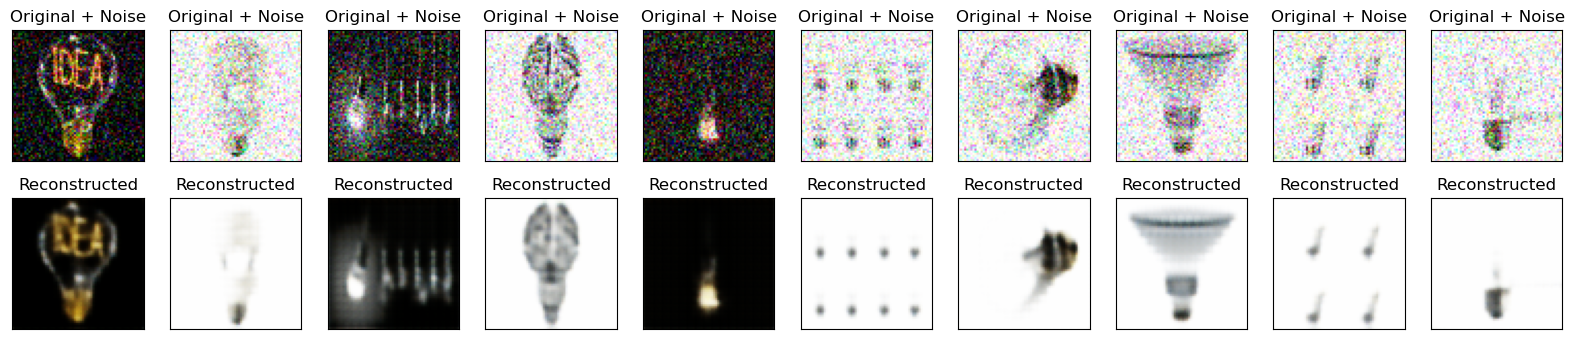

In [17]:
# Making predictions on test set
# Converting test set to NumPy arrays
test_set = np.concatenate([x for x, _ in test_set], axis = 0) # option 2
#test_set = np.concatenate(test_set, axis = 0)

# Reshaping test set to match the expected input shape
test_set = np.reshape(test_set, (-1, 64, 64, 3))

# Adding noise to test images
test_noisy = test_set + noise_factor * np.random.normal(size = test_set.shape)

# # Clipping the test noisy images to the range [0, 1]
test_noisy = np.clip(test_noisy, 0., 1.)

# Predictions
predictions = autoencoder.predict(test_set)

# Display some test set examples along with their corresponding predictions
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # displaying original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_noisy[i])
    plt.title("Original + Noise")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # displaying reconstructed images
    bx = plt.subplot(2, n, i + n + 1)
    plt.imshow(predictions[i])
    plt.title("Reconstructed")
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()

That was a good prediction by the autoencoder on the test dataset.